In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
sys.path.insert(0,'../')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3598356 cuda: True


# Parameters

In [3]:
# Model Paramters:
NUM_PIXELS = 784
NUM_HIDDEN1 = 400
NUM_HIDDEN2 = 200
NUM_STYLE = 10 
NUM_DIGITS = 10

# Training Parameters:
NUM_SAMPLES = 1
NUM_BATCH = 128
NUM_EPOCHS = 200
LABEL_FRACTION = 0.1
LEARNING_RATE = 1e-3
EPS = 1e-9
BIAS_TRAIN = (60000 - 1) / (NUM_BATCH - 1)
BIAS_TEST = (10000 - 1) / (NUM_BATCH - 1)
CUDA = torch.cuda.is_available()

# LOSS parameters:
ALPHA = 0.1
BETA = (4.0, 1.0, 1.0, 0.0, 1.0) 

# Encoder Model

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, num_pixels=NUM_PIXELS,
                       num_hidden1=NUM_HIDDEN1,
                       num_hidden2=NUM_HIDDEN2,
                       num_style=NUM_STYLE,
                       num_digits=NUM_DIGITS):
        
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
                            nn.Linear(num_pixels, num_hidden1),
                            nn.ReLU())
        self.digit_log_weights = nn.Linear(num_hidden1, num_digits)
        self.digit_temp = 0.66
        self.style_mean = nn.Sequential(
                            nn.Linear(num_hidden1 + num_digits, num_hidden2),
                            nn.ReLU(),
                            nn.Linear(num_hidden2, num_style))
        self.style_log_std = nn.Sequential(
                                nn.Linear(num_hidden1 + num_digits, num_hidden2),
                                nn.ReLU(),
                                nn.Linear(num_hidden2, num_style))

    @expand_inputs
    def forward(self, images, labels=None, num_samples=NUM_SAMPLES):
        q = probtorch.Trace()
        hidden = self.enc_hidden(images)
        digits = q.concrete(logits=self.digit_log_weights(hidden),
                            temperature=self.digit_temp,
                            value=labels,
                            name='y')        
        hidden2 = torch.cat([digits, hidden] , -1)
        styles_mean = self.style_mean(hidden2)
        styles_std = self.style_log_std(hidden2).exp()
        q.normal(loc=styles_mean,
                 scale=styles_std,
                 name='z')
        return q 

# Decoder Model

In [5]:
def binary_cross_entropy(x_mean, x, EPS=1e-9):
    return - (torch.log(x_mean + EPS) * x + 
              torch.log(1 - x_mean + EPS) * (1 - x)).sum(-1)

class Decoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS,
                       num_hidden1=NUM_HIDDEN1,
                       num_hidden2=NUM_HIDDEN2,
                       num_style=NUM_STYLE,
                       num_digits=NUM_DIGITS):
        
        super(self.__class__, self).__init__()
        self.dec_hidden = nn.Sequential(
                            nn.Linear(num_style + num_digits, num_hidden2),
                            nn.ReLU(),
                            nn.Linear(num_hidden2, num_hidden1),
                            nn.ReLU())
        
        self.num_style = num_style
        self.num_digits = num_digits
        self.digit_temp = 0.66
        self.dec_images = nn.Sequential(
                            nn.Linear(num_hidden1, num_pixels),
                            nn.Sigmoid())
        
    def forward(self, images, q=None, num_samples=NUM_SAMPLES, batch_size=NUM_BATCH):
        p = probtorch.Trace()
        digit_log_weights = torch.zeros(num_samples, batch_size, self.num_digits)
        style_mean = torch.zeros(num_samples, batch_size, self.num_style)
        style_std = torch.ones(num_samples, batch_size, self.num_style)
        
        if CUDA:
            digit_log_weights = digit_log_weights.cuda()
            style_mean = style_mean.cuda()
            style_std = style_std.cuda()
        
        digits = digits = p.concrete(logits=digit_log_weights,
                                     temperature=self.digit_temp,
                                     value=q['y'],
                                     name='y')
        
        styles = p.normal(loc=style_mean,
                          scale=style_std,
                          value=q['z'],
                          name='z')
        
        hiddens = self.dec_hidden(torch.cat([digits, styles], -1))
        images_mean = self.dec_images(hiddens)
        p.loss(binary_cross_entropy, images_mean, images, name='images')  
        return p

# Loss

In [6]:
def elbo(q, p, alpha=ALPHA, beta=BETA, bias=1.0):
    return probtorch.objectives.marginal.elbo(q, p, sample_dim=0, batch_dim=1,
                                              alpha=alpha, beta=beta, bias=bias)

# Data

In [7]:
from torchvision import datasets, transforms
import os 
DATA_PATH = '../../mnist'

if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)

train_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=True, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 
test_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=False, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 

# Training and Testing

In [8]:
enc = Encoder()
dec = Decoder()
if CUDA:
    enc.cuda()
    dec.cuda()
optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),
                              lr=LEARNING_RATE)


In [9]:
def train(data, enc, dec, optimizer, 
          label_mask={}, label_fraction=LABEL_FRACTION):
    epoch_elbo = 0.0
    enc.train()
    dec.train()
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size(0) == NUM_BATCH:
            N += NUM_BATCH
            images = images.view(-1, NUM_PIXELS)
            labels_onehot = torch.zeros(NUM_BATCH, NUM_DIGITS)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
            labels_onehot = torch.clamp(labels_onehot, EPS, 1-EPS)
            if CUDA:
                images = images.cuda()
                labels_onehot = labels_onehot.cuda()
            optimizer.zero_grad()
            if b not in label_mask:
                label_mask[b] = (random() < label_fraction)
            if label_mask[b]:
                q = enc(images, labels_onehot, num_samples=NUM_SAMPLES)
            else:
                q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES, batch_size=NUM_BATCH)
            loss = -elbo(q, p, bias=BIAS_TRAIN)
            loss.backward()
            optimizer.step()
            if CUDA:
                loss = loss.cpu()
            epoch_elbo -= loss.item()
    return epoch_elbo / N, label_mask


def test(data, enc, dec, infer=True):
    enc.eval()
    dec.eval()
    epoch_elbo = 0.0
    epoch_correct = 0
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES, batch_size=NUM_BATCH)
            batch_elbo = elbo(q, p, bias=BIAS_TEST)
            if CUDA:
                batch_elbo = batch_elbo.cpu()
            epoch_elbo += batch_elbo.data.numpy()
            
            log_p = p.log_joint(0, 1)
            log_q = q.log_joint(0, 1)
            log_w = log_p - log_q
            w = torch.nn.functional.softmax(log_w, 0)
            y_samples = q['y'].value
            y_expect = (w.unsqueeze(-1) * y_samples).sum(0)
            _ , y_pred = y_expect.data.max(-1)
            if CUDA:
                    y_pred = y_pred.cpu()
            epoch_correct += (labels == y_pred).float().sum()
    return epoch_elbo / N, epoch_correct / N


In [10]:
import time
from random import random

mask = {}
for e in range(NUM_EPOCHS):
    train_start = time.time()
    train_elbo, mask = train(train_data, enc, dec, 
                             optimizer, mask, LABEL_FRACTION)
    train_end = time.time()
    test_start = time.time()
    test_elbo, test_accuracy = test(test_data, enc, dec)
    test_end = time.time()
    
    print('[Epoch %d] Train: ELBO %.4e (%ds) Test: ELBO %.4e, Accuracy %0.3f (%ds)' % (
            e, train_elbo, train_end - train_start, 
            test_elbo, test_accuracy, test_end - test_start))

[Epoch 0] Train: ELBO -1.4160e+00 (15s) Test: ELBO -1.1439e+00, Accuracy 0.295 (1s)
[Epoch 1] Train: ELBO -1.0481e+00 (15s) Test: ELBO -1.0220e+00, Accuracy 0.399 (1s)
[Epoch 2] Train: ELBO -9.7480e-01 (15s) Test: ELBO -9.7414e-01, Accuracy 0.485 (1s)
[Epoch 3] Train: ELBO -9.3558e-01 (14s) Test: ELBO -9.4044e-01, Accuracy 0.581 (1s)
[Epoch 4] Train: ELBO -9.0718e-01 (14s) Test: ELBO -9.2097e-01, Accuracy 0.617 (1s)
[Epoch 5] Train: ELBO -8.8782e-01 (16s) Test: ELBO -9.0257e-01, Accuracy 0.685 (1s)
[Epoch 6] Train: ELBO -8.7449e-01 (15s) Test: ELBO -8.9119e-01, Accuracy 0.719 (1s)
[Epoch 7] Train: ELBO -8.6363e-01 (14s) Test: ELBO -8.8418e-01, Accuracy 0.759 (1s)
[Epoch 8] Train: ELBO -8.5517e-01 (16s) Test: ELBO -8.7583e-01, Accuracy 0.776 (1s)
[Epoch 9] Train: ELBO -8.4736e-01 (13s) Test: ELBO -8.7255e-01, Accuracy 0.791 (1s)
[Epoch 10] Train: ELBO -8.4077e-01 (12s) Test: ELBO -8.6619e-01, Accuracy 0.809 (1s)
[Epoch 11] Train: ELBO -8.3594e-01 (12s) Test: ELBO -8.6405e-01, Accuracy 0

### Visualize Encodings:

In [11]:
# Get all the embeddings
Zs = np.zeros((len(train_data),NUM_BATCH, NUM_STYLE))
for b, (images, labels) in enumerate(train_data):
        if images.size()[0] == NUM_BATCH:
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            q = enc(images, num_samples=NUM_SAMPLES)
            z = q['z'].value.cpu().data.squeeze().numpy()
            Zs[b] = z
Zs = Zs.reshape(-1,NUM_STYLE)

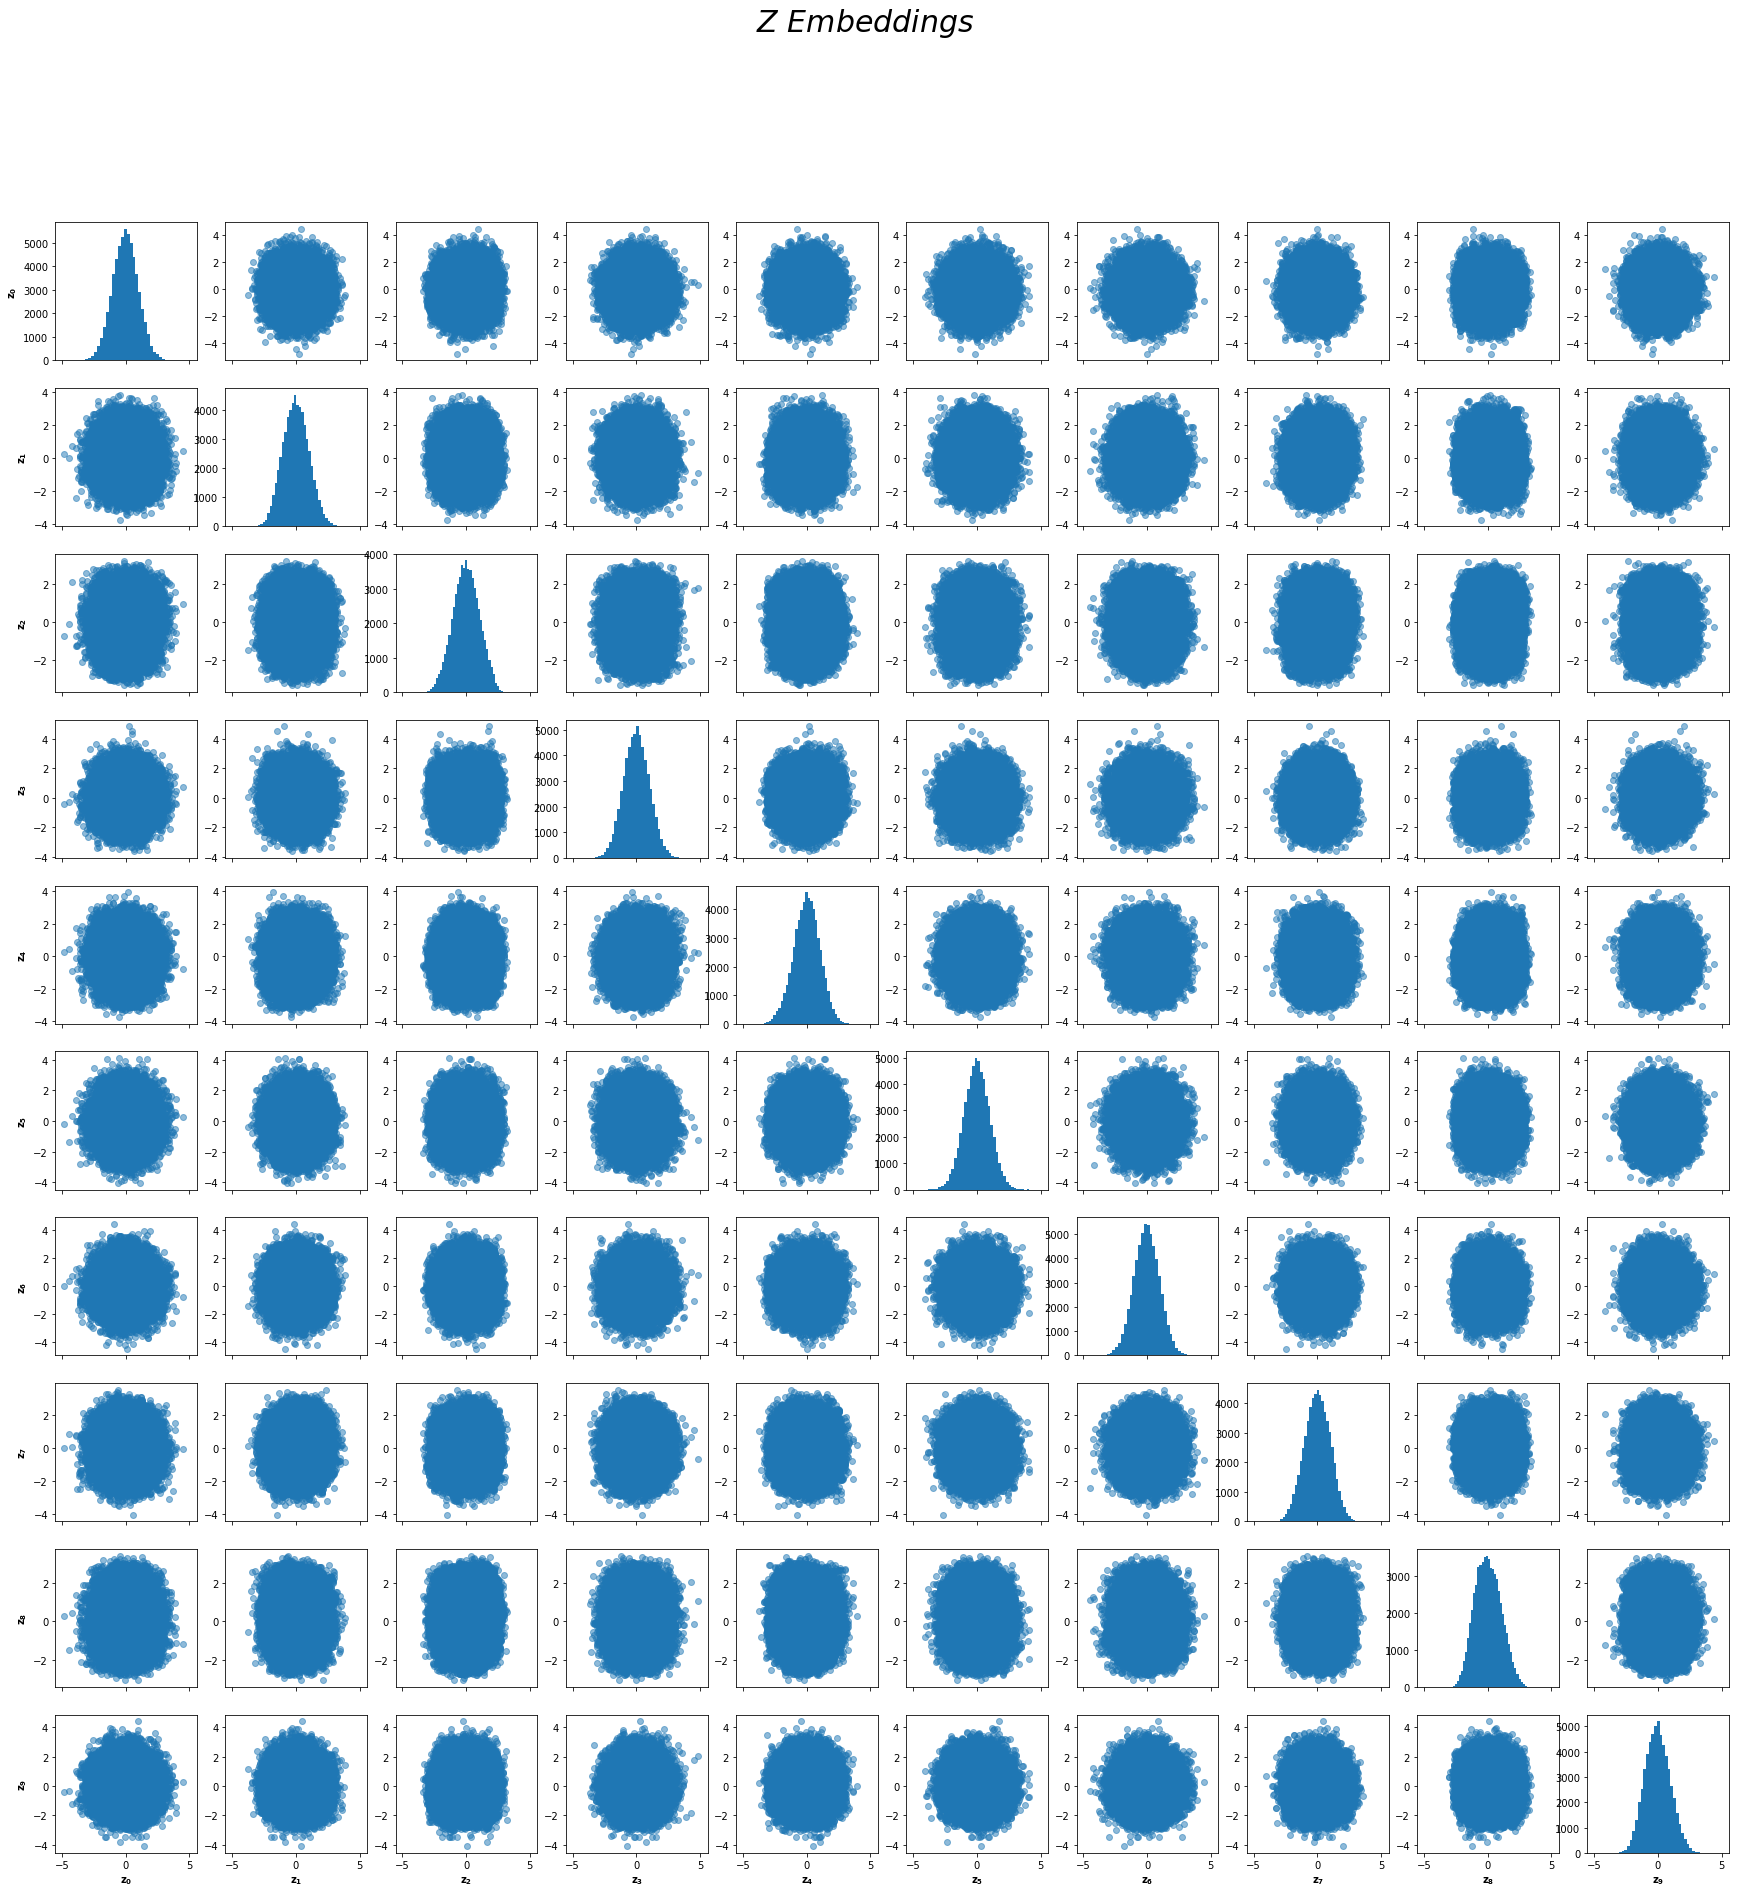

In [12]:
f, axarr = plt.subplots(NUM_STYLE, NUM_STYLE, figsize=(30, 30), sharex=True)
f.suptitle(r'$Z \ Embeddings$' , fontsize=30)

for i in range(NUM_STYLE):
    axarr[NUM_STYLE-1,i].set_xlabel(r'$\mathbf{z_{%d}}$' % i, fontsize=10)
    axarr[i,0].set_ylabel(r'$\mathbf{z_{%d}}$' % i, fontsize=10)
    for j in range(NUM_STYLE):
        if i==j:
            axarr[j,i].hist(Zs[:,i], bins=40)
        else:
            axarr[j,i].scatter(Zs[:,i],Zs[:,j],alpha=0.5)
            
plt.show()

### Latent Traversals: 

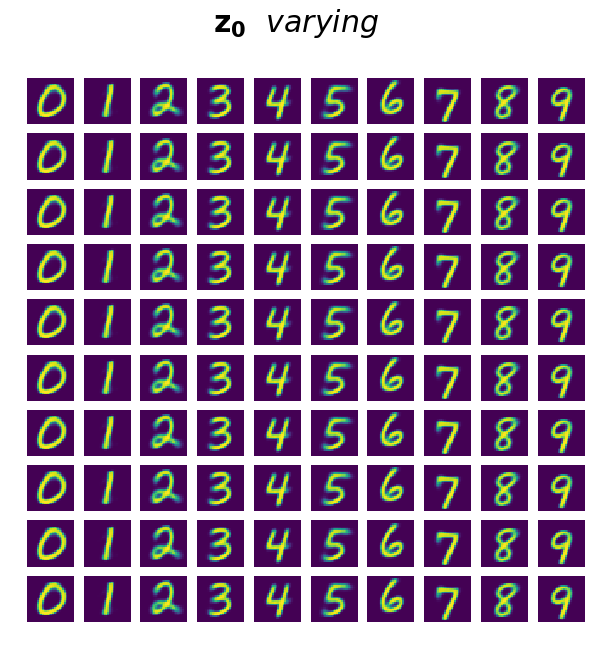

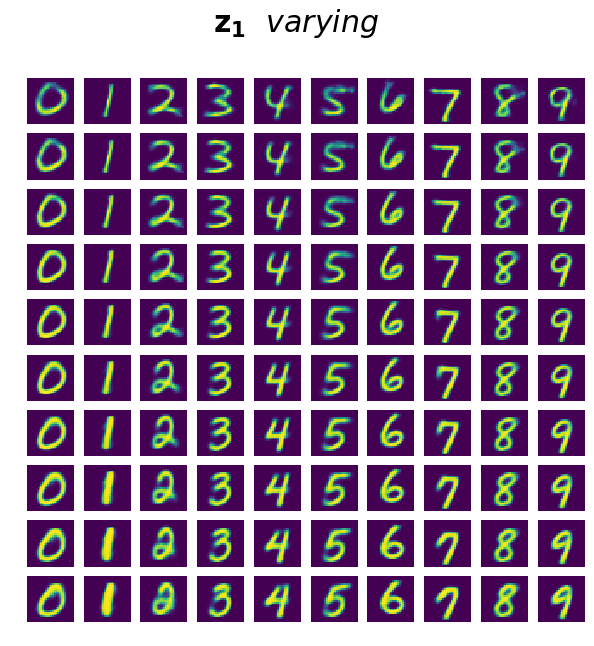

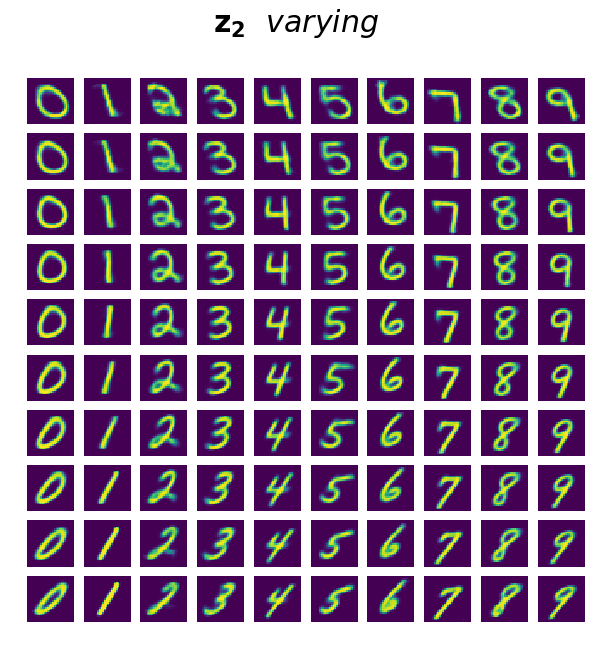

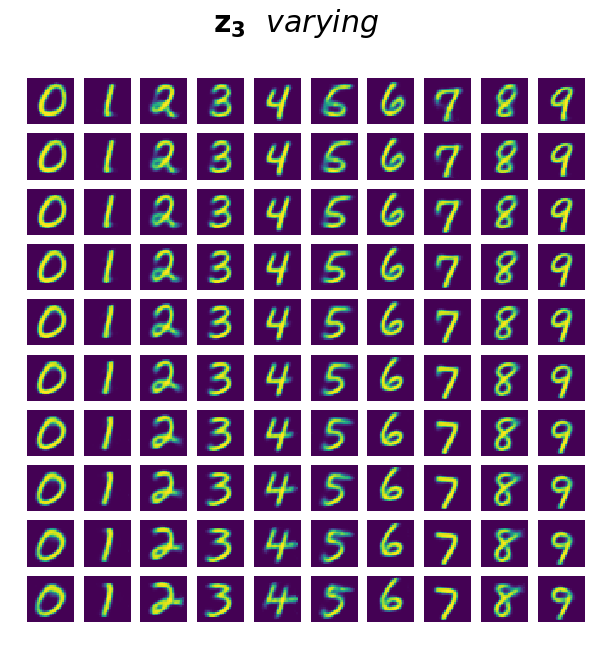

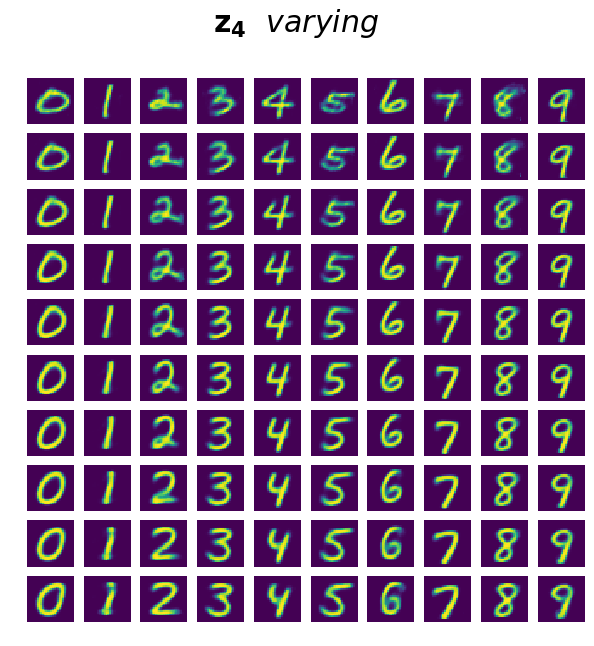

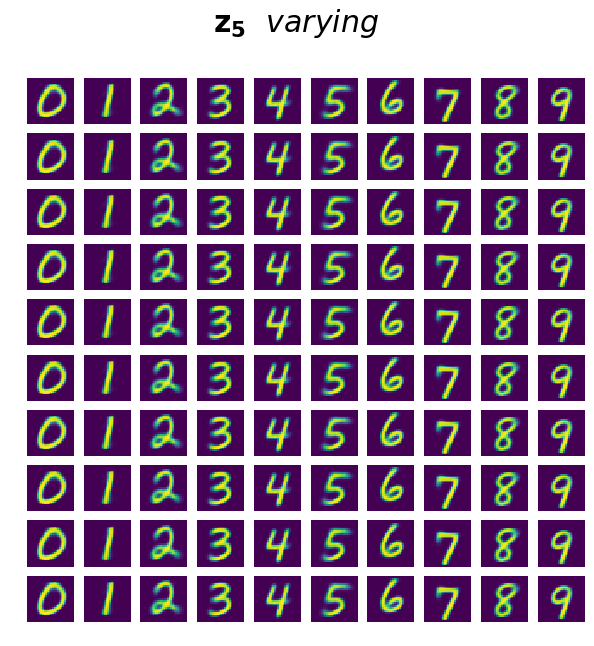

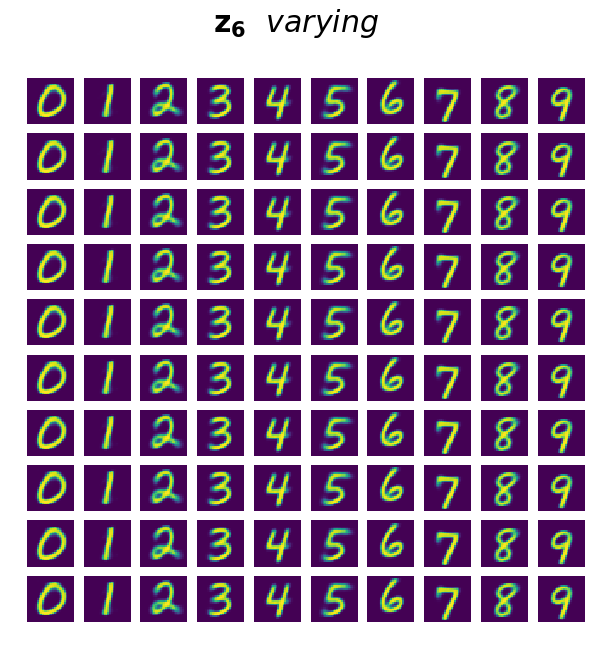

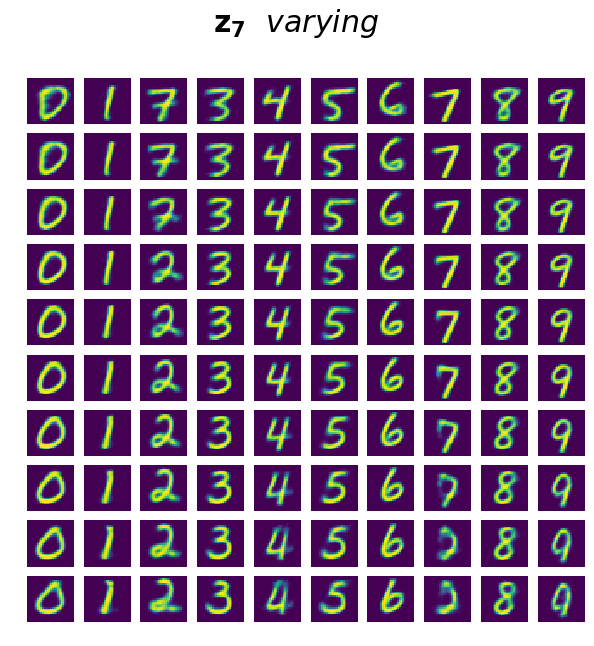

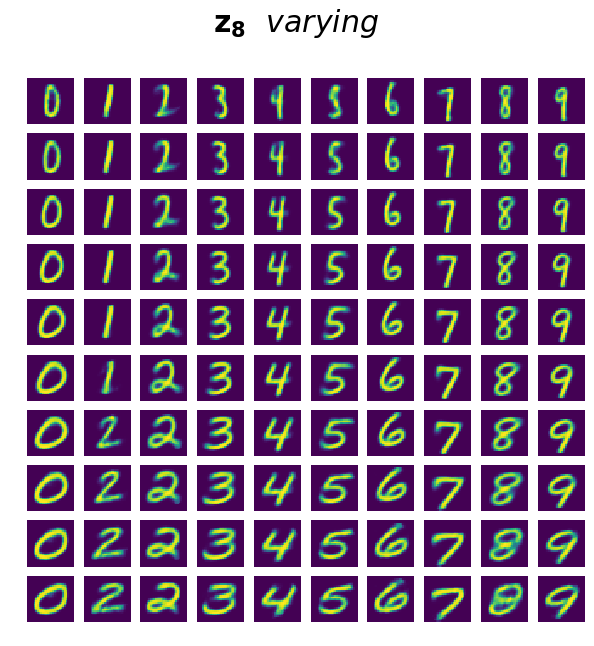

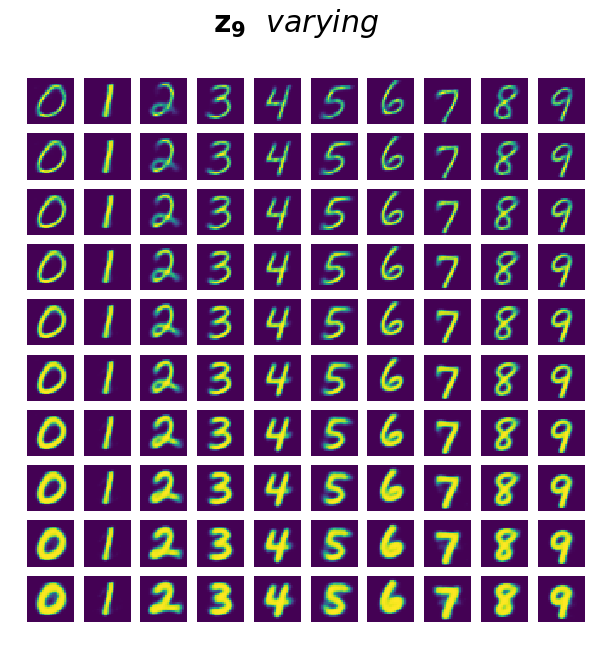

In [13]:
def vary_z2(index, zmin, zmax):
    f, axarr = plt.subplots(10,10,figsize=(10,10),sharey=True)
    f.suptitle(r'$\mathbf{z_{%d}} \ \  varying$' % index , fontsize=30)
    z_range = np.linspace(zmin,zmax,num=10)
    
    for i in range(10):
        for j in range(10):
            null_image = torch.zeros((1,784))
            z = torch.zeros((1,10))
            y_hot = torch.zeros((1,10))
            z[0,index] = z_range[i]
            y_hot[0,j] = 1
            if CUDA:
                z = z.cuda()
                y_hot = y_hot.cuda()
                null_image = null_image.cuda()
            q_null = {'z': z, 'y':y_hot}
            p = dec(null_image, q_null, num_samples=NUM_SAMPLES, batch_size=1) 
            image = p['images']
            image = image.value.cpu().data.numpy().reshape(28,28)
            axarr[i,j].imshow(image)
            axarr[i,j].axis('off')
            
    return None

for style in range(NUM_STYLE):
    vary_z2(style, -3, 3)
    plt.show()

### Latent Traversals for 'Thickness' and 'Angle':

In [14]:
def zi_vs_zj(z_index1, z_index2, zmin=3, zmax=3, num_z=10, digit=0):
    f, axarr = plt.subplots(num_z, num_z, figsize=(num_z, num_z), sharey=True)
    f.suptitle(r'$Digit: %s$' % digit , fontsize=30)
    z_range = np.linspace(zmin,zmax,num=num_z)
    
    for i in range(num_z):
        for j in range(num_z):
            null_image = torch.zeros((1, NUM_PIXELS))
            z = torch.zeros((1,NUM_STYLE))
            y_hot = torch.zeros((1,NUM_DIGITS))
            z[0,z_index1] = z_range[i]
            z[0,z_index2] = z_range[j]
            y_hot[0,digit] = 1
            if CUDA:
                null_image = null_image.cuda()
                z = z.cuda()
                y_hot = y_hot.cuda()
            q_null = {'z':z, 'y':y_hot}
            p = dec(null_image, q_null, num_samples=NUM_SAMPLES) 
            image = p['images']
            pixels = int(np.sqrt(NUM_PIXELS))
            image = image.value.cpu().data.numpy().reshape(pixels,pixels)
            axarr[i,j].imshow(image)
            axarr[i,j].axis('off')
    f.text(0.52, 0.08, r'$\mathbf{z_{%d}}$' % z_index2, ha='center', fontsize=20)
    f.text(0.09, 0.5, r'$\mathbf{z_{%d}}$' % z_index1, va='center', rotation='vertical', fontsize=20)

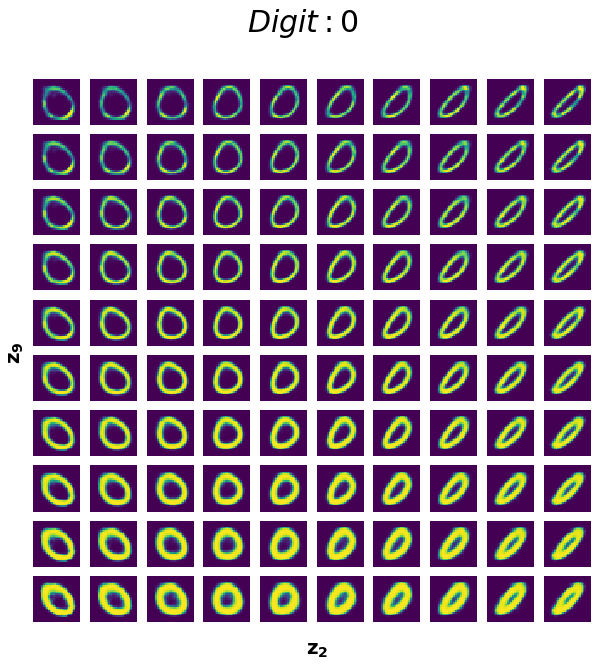

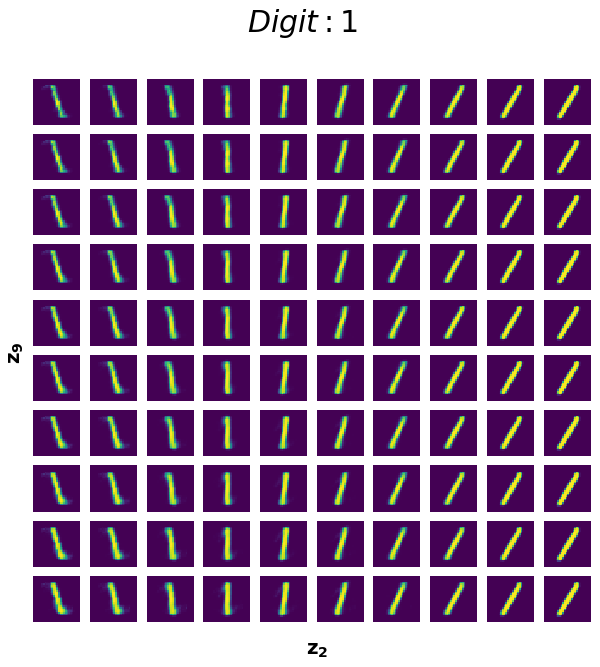

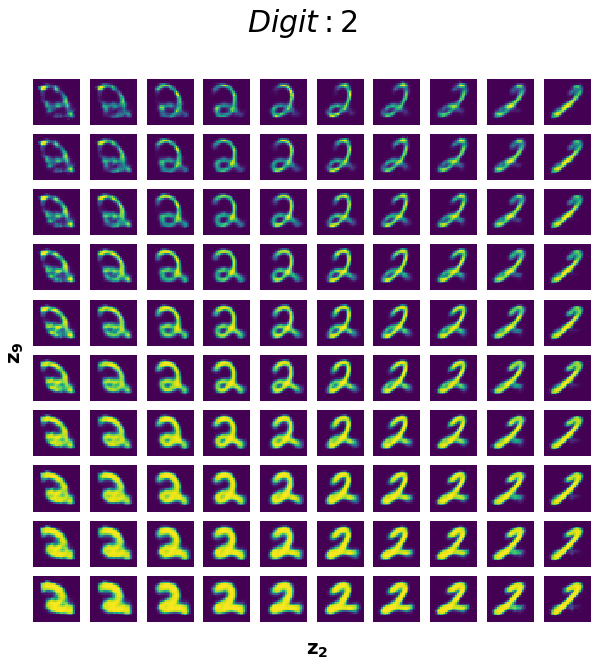

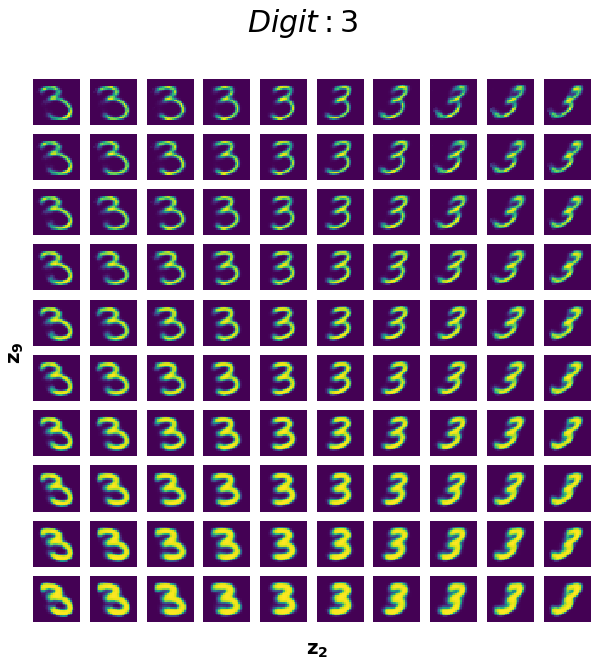

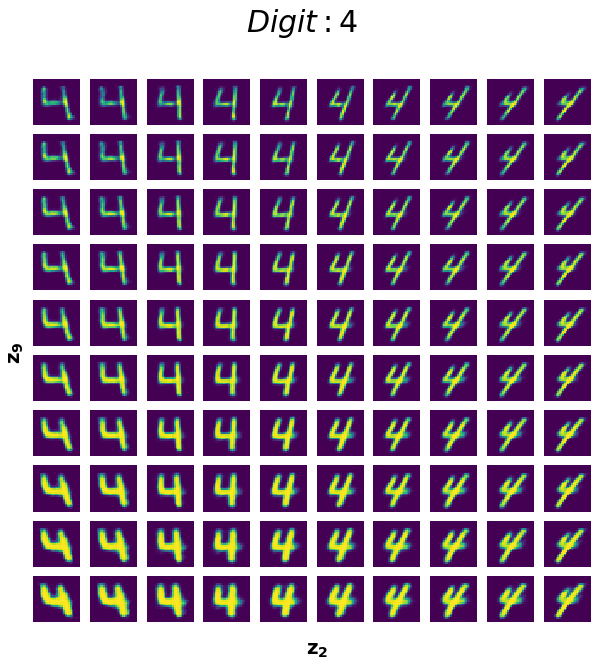

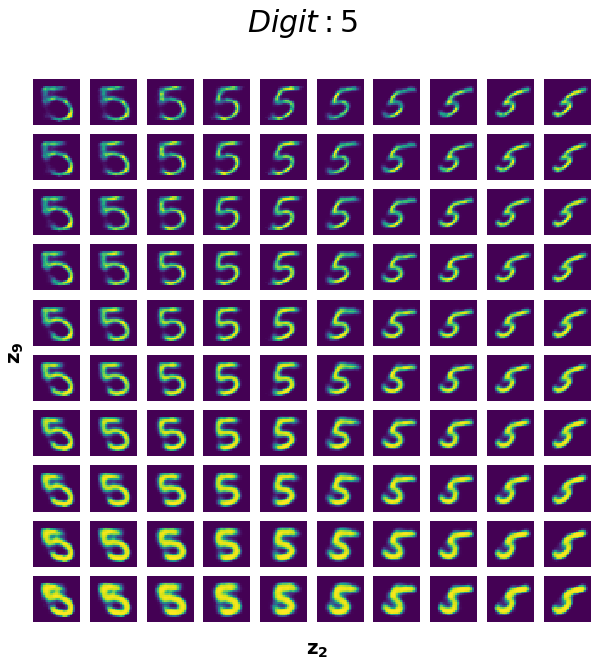

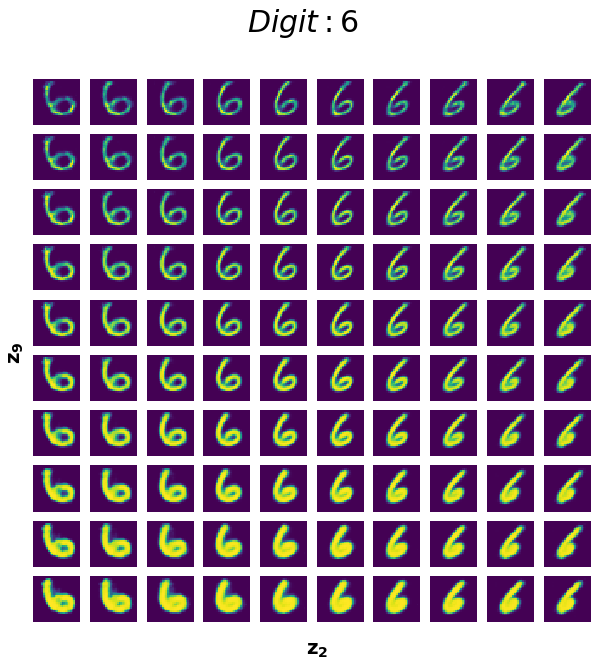

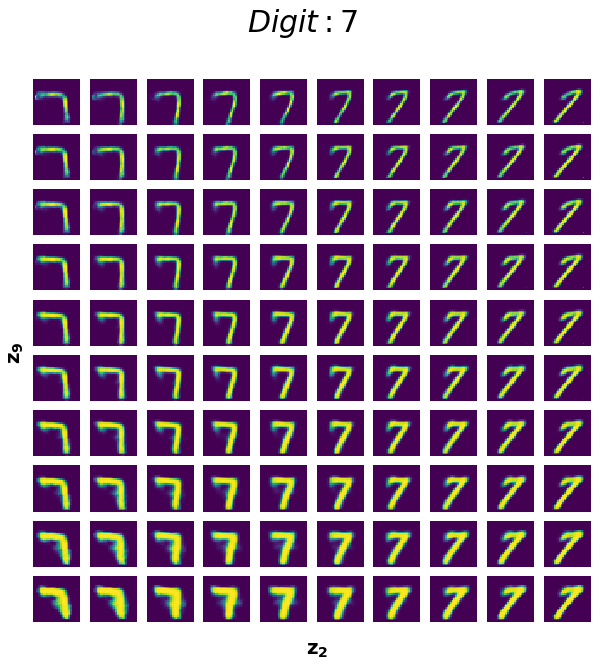

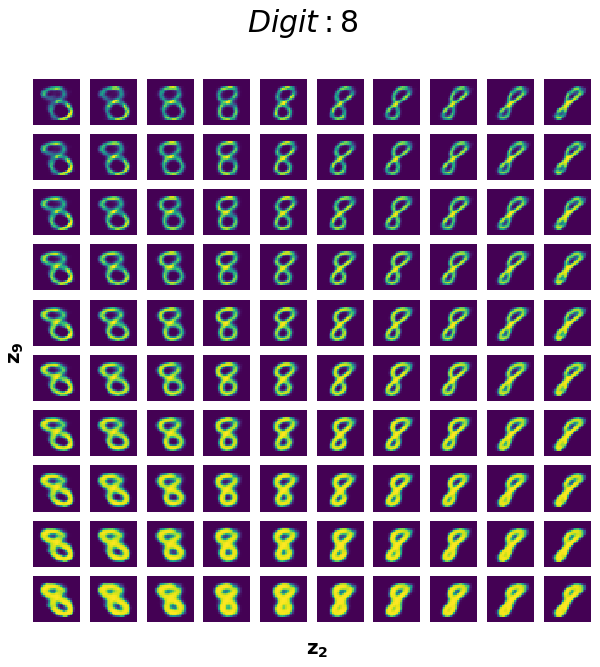

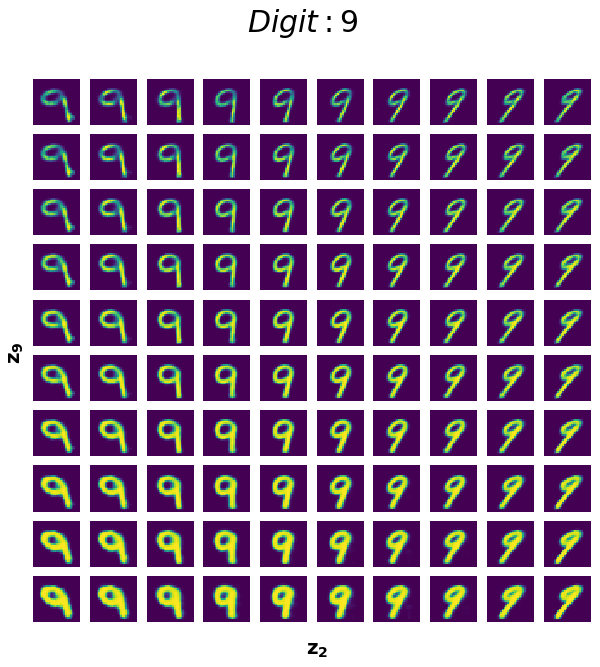

In [16]:
z_index1 = 9
z_index2 = 2
for digit in range(NUM_DIGITS):
    zi_vs_zj(z_index1, z_index2, zmin=-3, zmax=3, num_z=10, digit=digit)
    plt.show()